In [1]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
import torch.nn as nn
import cv2

In [11]:
# Get Test Set 
# !wget https://www2.seas.gwu.edu/~astylianou/hotels50k/test.tar.gz

# Formatting Data 
The available metadata is...
* Hotel Chain Name (93, including an 'unkown')
* Hotel Name (50,000) with associative Hotel Chain 
* Hotel Latitude and Longitude
* Image Datasource (travel_website and TraffickCam)
* People Crops (6,486)

In [2]:
t = Path('Hotels-50K/images/train/')
c = Path('Hotels-50K/images/people_crops/')

In [13]:
# images/train/chain_id/hotel_id/data_source/image_id.jpg
def extract_train(limit=False):
    data = []
    i = 0
    for chain_id in t.ls():
        for hotel_id in chain_id.ls():
            for d_source in hotel_id.ls():
                for image_id in d_source.ls():
                    i += 1
                    data.append([chain_id.name, 
                                 hotel_id.name, 
                                 d_source.name, 
                                 image_id.name,
                                 str(image_id)])
                    if limit and i > 200:
                        return data

def extract_occlusions(limit=False):
    data, i = [], 0
    for ci in c.ls():
        i += 1
        data.append([ci.name,
                    str(ci)])
        if limit and i > 200:
            return data

In [14]:
data = extract_train(limit=True)
occ = extract_occlusions(limit=True)

In [15]:
data_df = pd.DataFrame(data, columns=['chain_id',
                              'hotel_id',
                              'd_source',
                              'image_id',
                              'path'])
occ_df = pd.DataFrame(occ, columns=['occlusion_id', 'path'])
# df.to_csv(...) save + package for cloud

In [16]:
data_df.head()

,chain_id,hotel_id,d_source,image_id,path
0,61,49863,travel_website,1123686.jpg,Hotels-50K/images/train/61/49863/travel_websit...
1,61,49863,travel_website,1123684.jpg,Hotels-50K/images/train/61/49863/travel_websit...
2,61,49863,travel_website,1123685.jpg,Hotels-50K/images/train/61/49863/travel_websit...
3,61,49863,travel_website,1123682.jpg,Hotels-50K/images/train/61/49863/travel_websit...
4,61,49863,travel_website,1123683.jpg,Hotels-50K/images/train/61/49863/travel_websit...


In [17]:
occ_df.head()

,occlusion_id,path
0,8820.png,Hotels-50K/images/people_crops/8820.png
1,14392.png,Hotels-50K/images/people_crops/14392.png
2,348.png,Hotels-50K/images/people_crops/348.png
3,25629.png,Hotels-50K/images/people_crops/25629.png
4,29013.png,Hotels-50K/images/people_crops/29013.png


# Creating Data Bunch

## Occlusion Generator
See occlusion notes at the end of the notebook for a walkthrough...

In [101]:
# apply occlusions to training images
def _occlusion(x):
#     if np.random.uniform() < .5:
    if True:
        x = apply_occlusion(x)
    return x
occlusion = TfmPixel(_occlusion)

In [102]:
def apply_occlusion(img, occlusion_idx=None, scale_resize=1.):
    img_c, img_h, img_w = img.shape
    
    # load occlusion
    # TODO: optimize for faster imread + uniform sampling across crops
    occ_idx = np.random.randint(len(occ_df)) if not occlusion_idx else occlusion_idx
    occ_path = occ_df.loc[occ_idx].path 
    occ = cv2.imread(occ_path)

    # random resize taking up < 80% of image 
    while True:
        resized_occ = cv2.resize(occ, (0, 0),
                               fx=max(np.random.uniform(low=0.1, high=0.7) * scale_resize, 0.4), 
                               fy=max(np.random.uniform(low=0.1, high=0.7) * scale_resize, 0.4))
        percent_filled = np.sum(resized_occ[:, :, 0] // 255) / (img_h * img_w)
        h, w, _ = resized_occ.shape
    
        if percent_filled < 0.8 and h < img_h and w < img_w: 
            occ_mask = (1 - resized_occ // 255)
            break
    
    # get info 
    occ_h, occ_w, _ = occ_mask.shape
    d_height = img_h - occ_h 
    d_width = img_w - occ_w
    
    # random placement 
    p_top = np.random.uniform() 
    p_left = np.random.uniform() 
    top_fill = int(d_height * p_top)
    bottom_fill = d_height - top_fill
    left_fill = int(d_width * p_left)
    right_fill = d_width - left_fill
    
    fit_occ_mask = cv2.copyMakeBorder(occ_mask, top_fill, bottom_fill, left_fill, right_fill, cv2.BORDER_CONSTANT)
    tensor_occ_mask = torch.from_numpy(1 - fit_occ_mask[:, :, 0]).type(torch.float)

    return tensor_occ_mask * img    

## Fast.ai DataBunch

In [103]:
batch_size = 10
img_size = 224
ds_tfms = get_transforms(xtra_tfms=[occlusion()])
label_col = 1 # hotel_id


data = ImageDataBunch.from_df('.', 
                              data_df, 
                              label_col=label_col,
                              fn_col=-1, 
                              ds_tfms=ds_tfms, 
                              size=img_size,
                              bs=batch_size)

# View Data

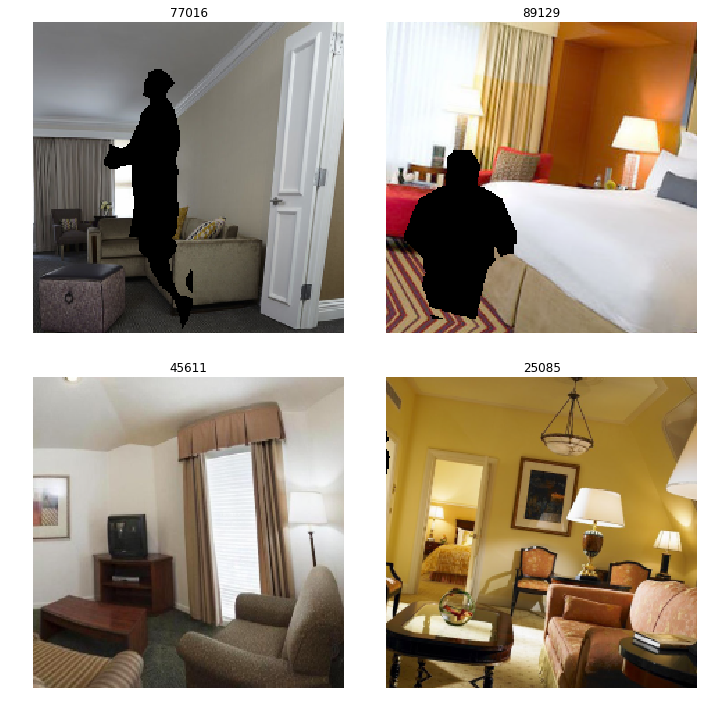

In [104]:
data.show_batch(rows=2, figsize=(10, 10))

# Training 

In [127]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [138]:
learn.fit_one_cycle(1)

# Applying the Occlusion

In [31]:
from matplotlib import pyplot as plt

In [32]:
def view(img):
    plt.imshow(img[:,:,::-1])

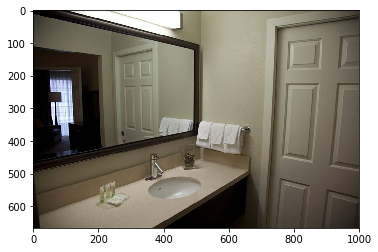

In [33]:
img_path = data_df.loc[0].path
img = cv2.imread(img_path)
view(img)

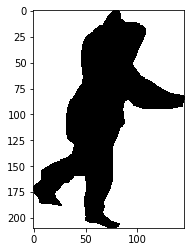

In [52]:
occ_path = occ_df.loc[0].path
occ = cv2.imread(occ_path)
view(occ)

In [53]:
# binary mask
occ_mask = (1 - occ // 255)

In [54]:
occ_h, occ_w, _ = occ_mask.shape
img_h, img_w, _ = img.shape

In [55]:
d_height = img_h - occ_h 
d_width = img_w - occ_w

In [56]:
d_height, d_width

(457, 854)

In [57]:
# zero fill 
fit_occ_mask = cv2.copyMakeBorder(occ_mask, d_height, 0, d_width, 0, cv2.BORDER_CONSTANT)

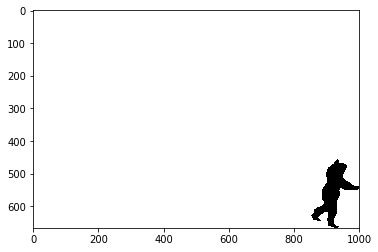

In [58]:
view((1 - fit_occ_mask) * 255)

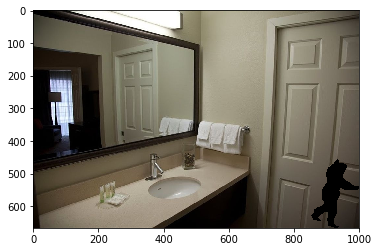

In [59]:
view((1 - fit_occ_mask) * img)

## Random Placement 

In [108]:
# % fill top + left (0.5, 0.5 for center)
p_top = np.random.uniform() 
p_left = np.random.uniform() 

top_fill = int(d_height * p_top)
bottom_fill = d_height - top_fill
left_fill = int(d_width * p_left)
right_fill = d_width - left_fill

In [109]:
# zero fill 
fit_occ_mask = cv2.copyMakeBorder(occ_mask, top_fill, bottom_fill, left_fill, right_fill, cv2.BORDER_CONSTANT)

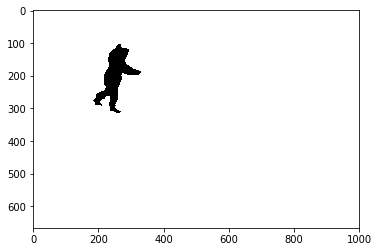

In [110]:
view((1 - fit_occ_mask) * 255)

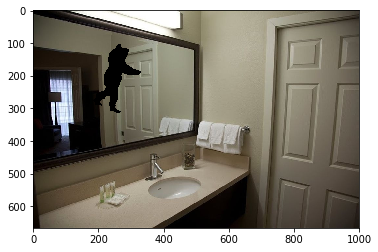

In [111]:
view((1 - fit_occ_mask) * img)

## Random Sizes 
- dont occupy more than 80% of original image (dataset max)

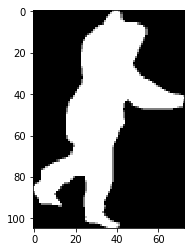

In [169]:
resized_image = cv2.resize(occ_mask * 255, (0, 0), fx=0.5, fy=0.5)
view(resized_image)

In [93]:
occ_mask.shape, resized_image.shape

((210, 146, 3), (105, 73, 3))

In [178]:
# % of image filled by mask 
np.sum(resized_image[:, :, 0] // 255) / (img_h * img_w)

0.0038530734632683658